In [126]:
#Import Tools
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import json
import requests
import openpyxl

In [127]:
# Gives adjacency dictionary (not mine)
edge_dict={}
def create_edge_dict(graph):
    for i, n in G.adjacency():
        # print("i is",i)
        # print("n is",n)
        edge_dict[i] = list(n)
    return edge_dict

# Gives duplicate items in a list (not mine)
def list_duplicates(seq):
  seen = set()
  seen_add = seen.add
  # adds all elements it doesn't know yet to seen and all other to seen_twice
  seen_twice = set( x for x in seq if x in seen or seen_add(x) )
  # turn the set into a list (as requested)
  return list( seen_twice )


#(https://www.geeksforgeeks.org/python-merge-two-lists-into-list-of-tuples/)
def merge(list1, list2):
      
    merged_list = []
    for i in range(max((len(list1), len(list2)))):
  
        while True:
            try:
                tup = (list1[i], list2[i])
            except IndexError:
                if len(list1) > len(list2):
                    list2.append('')
                    tup = (list1[i], list2[i])
                elif len(list1) < len(list2):
                    list1.append('')
                    tup = (list1[i], list2[i])
                continue
  
            merged_list.append(tup)
            break
    return merged_list


# function to check whether the list is empty or not
def is_list_empty(list):
    # checking the length
    if len(list) == 0:
        # returning true as length is 0
        return True
    # returning false as length is greater than 0
    return False

In [128]:
#retrieve data regarding vacant spaces
from openpyxl import load_workbook
workbook = load_workbook(filename="Node Information.xlsx")
workbook.sheetnames
sheet1 = workbook.worksheets[0]
sheet2 = workbook.worksheets[1]

#create dictionary based on excel worksheet
vacant_spaces={}
for value in sheet1.iter_rows(min_row=2, values_only=True):
    for index,item in enumerate(value):
        vacant_spaces[value[0]]={}
        vacant_spaces[value[0]]["location"]=value[1]
        vacant_spaces[value[0]]["tag"]=value[6]
        vacant_spaces[value[0]]["building"]=value[3]
        vacant_spaces[value[0]]["size_real"]=value[2]
        vacant_spaces[value[0]]["loc_building"]=value[4]
        vacant_spaces[value[0]]["orientation"]=value[5]
        vacant_spaces[value[0]]["node_type"]=value[7]

#interpret data
#Rules:
#structure (roof:1,ground:3,outside:3,basement:3,intermediate:2)
#solar (roof:3,
#       basement:1
#       ground & S,SW,SE:3,
#       ground $ E,W:2
#       ground $ N,NE,NW:1
#       outside & S,SW,SE:3,
#       outside $ E,W:2
#       outside $ N,NE,NW:1
#       intermediate & S,SW,SE:3,
#       intermediate & E,W:2
#       intermediate & N,NE,NW:1
#size (0-100 size:1)
#     (101-500 size:2)
#     (500-... size:3)

for space in vacant_spaces:
    if vacant_spaces[space]["loc_building"]=="roof":
        vacant_spaces[space]["structure"]=1
        vacant_spaces[space]["solar"]=3
    if vacant_spaces[space]["loc_building"]=="basement":
        vacant_spaces[space]["structure"]=3
        vacant_spaces[space]["solar"]=1
    if (vacant_spaces[space]["loc_building"]=="ground") and (((vacant_spaces[space]["orientation"])=="S") or ((vacant_spaces[space]["orientation"])=="SE") or ((vacant_spaces[space]["orientation"])=="SW")):
        vacant_spaces[space]["solar"]=3
        vacant_spaces[space]["structure"]=3
    if (vacant_spaces[space]["loc_building"]=="ground") and (((vacant_spaces[space]["orientation"])=="N") or ((vacant_spaces[space]["orientation"])=="NE") or ((vacant_spaces[space]["orientation"])=="NW")):
        vacant_spaces[space]["solar"]=1
        vacant_spaces[space]["structure"]=3
    if (vacant_spaces[space]["loc_building"]=="ground") and (((vacant_spaces[space]["orientation"])=="E") or ((vacant_spaces[space]["orientation"])=="W")):
        vacant_spaces[space]["solar"]=2
        vacant_spaces[space]["structure"]=3
    if (vacant_spaces[space]["loc_building"]=="intermediate") and (((vacant_spaces[space]["orientation"])=="S") or ((vacant_spaces[space]["orientation"])=="SE") or ((vacant_spaces[space]["orientation"])=="SW")):
        vacant_spaces[space]["solar"]=3
        vacant_spaces[space]["structure"]=2
    if (vacant_spaces[space]["loc_building"]=="intermediate") and (((vacant_spaces[space]["orientation"])=="N") or ((vacant_spaces[space]["orientation"])=="NE") or ((vacant_spaces[space]["orientation"])=="NW")):
        vacant_spaces[space]["solar"]=1
        vacant_spaces[space]["structure"]=2
    if (vacant_spaces[space]["loc_building"]=="intermediate") and (((vacant_spaces[space]["orientation"])=="E") or ((vacant_spaces[space]["orientation"])=="W")):
        vacant_spaces[space]["solar"]=2
        vacant_spaces[space]["structure"]=2
    if (vacant_spaces[space]["loc_building"]=="outside") and (((vacant_spaces[space]["orientation"])=="S") or ((vacant_spaces[space]["orientation"])=="SE") or ((vacant_spaces[space]["orientation"])=="SW")):
        vacant_spaces[space]["solar"]=3
        vacant_spaces[space]["structure"]=3
    if (vacant_spaces[space]["loc_building"]=="outside") and (((vacant_spaces[space]["orientation"])=="N") or ((vacant_spaces[space]["orientation"])=="NE") or ((vacant_spaces[space]["orientation"])=="NW")):
        vacant_spaces[space]["solar"]=1
        vacant_spaces[space]["structure"]=3
    if (vacant_spaces[space]["loc_building"]=="outside") and (((vacant_spaces[space]["orientation"])=="E") or ((vacant_spaces[space]["orientation"])=="W")):
        vacant_spaces[space]["solar"]=2
        vacant_spaces[space]["structure"]=3

#interpret size based on predefined ranges
for space in vacant_spaces:
    if vacant_spaces[space]["size_real"]<=100:
        vacant_spaces[space]["size"]=1
    if (vacant_spaces[space]["size_real"]>100) and (vacant_spaces[space]["size_real"]<=500) :
        vacant_spaces[space]["size"]=2
    if (vacant_spaces[space]["size_real"]>500):
        vacant_spaces[space]["size"]=3
    
#remove orientation,loc_building,size_real
for space in vacant_spaces:
    vacant_spaces[space].pop("orientation")
    vacant_spaces[space].pop("size_real")
    vacant_spaces[space].pop("loc_building")   
     
#retrieve waste sources
#create dictionary based on excel worksheet
wastes={}
for value in sheet2.iter_rows(min_row=2, values_only=True):
    for index,item in enumerate(value):
        wastes[value[0]]={}
        wastes[value[0]]["location"]=value[1]
        wastes[value[0]]["source"]=value[2]
        wastes[value[0]]["tag"]=value[5]
        wastes[value[0]]["type"]=value[3]
        wastes[value[0]]["quantity"]=value[4]
        wastes[value[0]]["node_type"]="waste"


#assign ranges to quantities
for waste in wastes:
    if wastes[waste]["type"]=="W1":
        if wastes[waste]["quantity"]<= 91852:
            wastes[waste]["size"]=1
        if (wastes[waste]["quantity"]>91852) and (wastes[waste]["quantity"]<=459261):
            wastes[waste]["size"]=2
        if wastes[waste]["quantity"]>459261:
            wastes[waste]["size"]=3
    if wastes[waste]["type"]=="W2":
        if wastes[waste]["quantity"]<= 25000:
            wastes[waste]["size"]=1
        if (wastes[waste]["quantity"]>25000) and (wastes[waste]["quantity"]<=125000):
            wastes[waste]["size"]=2
        if wastes[waste]["quantity"]>125000:
            wastes[waste]["size"]=3
    if wastes[waste]["type"]=="W3":
        if wastes[waste]["quantity"]<= 5906:
            wastes[waste]["size"]=1
        if (wastes[waste]["quantity"]>5906) and (wastes[waste]["quantity"]<=29531):
            wastes[waste]["size"]=2
        if wastes[waste]["quantity"]>29531:
            wastes[waste]["size"]=3
    if wastes[waste]["type"]=="W4":
        if wastes[waste]["quantity"]<= 14100:
            wastes[waste]["size"]=1
        if (wastes[waste]["quantity"]>14100) and (wastes[waste]["quantity"]<=70500):
            wastes[waste]["size"]=2
        if wastes[waste]["quantity"]>70500:
            wastes[waste]["size"]=3
    if wastes[waste]["type"]=="W5":
        if wastes[waste]["quantity"]<= 7937:
            wastes[waste]["size"]=1
        if (wastes[waste]["quantity"]>7937) and (wastes[waste]["quantity"]<=39684):
            wastes[waste]["size"]=2
        if wastes[waste]["quantity"]>39684:
            wastes[waste]["size"]=3
    if wastes[waste]["type"]=="W6":
        if wastes[waste]["quantity"]<= 187612:
            wastes[waste]["size"]=1
        if (wastes[waste]["quantity"]>187612) and (wastes[waste]["quantity"]<=938060):
            wastes[waste]["size"]=2
        if wastes[waste]["quantity"]>938060:
            wastes[waste]["size"]=3
    if wastes[waste]["type"]=="W7":
        if wastes[waste]["quantity"]<= 100000:
            wastes[waste]["size"]=1
        if (wastes[waste]["quantity"]>100000) and (wastes[waste]["quantity"]<=500000):
            wastes[waste]["size"]=2
        if wastes[waste]["quantity"]>500000:
            wastes[waste]["size"]=3

#remove quantity
for waste in wastes:
    wastes[waste].pop("quantity")


In [129]:
#retrieve connections within radius=x
url = "https://raw.githubusercontent.com/erengozdeanil/UF-DecisionMaker/main/Edges.txt"
resp = requests.get(url)
edges = json.loads(resp.text)
#converts nested lists into a list of tuples
edge_coordinates100 = [tuple(i) for i in edges]
# print(tuple(edge_coordinates100))

#retrieve connections between vacant spaces within radius=x
url1="https://raw.githubusercontent.com/erengozdeanil/UF-DecisionMaker/main/Edges_vacant.txt"
resp1 = requests.get(url1)
edges1 = json.loads(resp1.text)
#converts nested lists into a list of tuples
nearby_space_coordinates = [tuple(i) for i in edges1]

#retrieve connections within radius=3x

#combine wastes and vacant_spaces
combined_dict=vacant_spaces.copy()
combined_dict.update(wastes)
# print(edge_coordinates100)
#replace coordinates with identifiers
# FOR NEARBY WASTE100
start=[]
end=[]
for couple in edge_coordinates100:
    for space in combined_dict:
        location=(combined_dict[space]["location"])
        # print("location",location)
        # print(item)
        if couple[0]==location:
            start.append(combined_dict[space]["tag"])
        if couple[1]==location:
            end.append(combined_dict[space]["tag"])               
nearby_waste100=list(zip(start,end))

# FOR NEARBY SPACE
start1=[]
end1=[]
for couple in nearby_space_coordinates:
    print(couple)
    for space in combined_dict:
        location=(combined_dict[space]["location"])
        # print("location",location)
        # print(item)
        if couple[0]==location:
            start1.append(combined_dict[space]["tag"])
        if couple[1]==location:
            end1.append(combined_dict[space]["tag"])               
nearby_space=list(zip(start1,end1))

('{64.79253, 69.821744, 0}', '{22.821687, 53.644416, 0}')
('{-53.645798, 20.542614, 0}', '{-83.924008, 48.665334, 0}')
('{-53.645798, 20.542614, 0}', '{-71.365198, 92.291458, 0}')
('{-53.645798, 20.542614, 0}', '{22.821687, 53.644416, 0}')
('{22.821687, 53.644416, 0}', '{64.79253, 69.821744, 0}')
('{22.821687, 53.644416, 0}', '{-53.645798, 20.542614, 0}')
('{-71.365198, 92.291458, 0}', '{-83.924008, 48.665334, 0}')
('{-71.365198, 92.291458, 0}', '{-53.645798, 20.542614, 0}')
('{-83.924008, 48.665334, 0}', '{-53.645798, 20.542614, 0}')
('{-83.924008, 48.665334, 0}', '{-71.365198, 92.291458, 0}')


In [130]:
#Dictionary of urban farming systems
    # UF1: Vermiculture, UF2: Aquaculture, UF3: Mushroom, UF4: NFT, UF5: Medai Beds, UF6: Raised Beds, UF7: Water Culture, UF8: Plant Factory, UF9: Aeroponics
    # "S" : supplementary system, "F" : food production system
    # 3 : high, 2 : medium, 1 : low, 0 : none
uf_systems = {
"UF1":{"tag":"UF1","type":"S","weight":3,"solar":1,"in":["W1","W2","W3","W6"],"supplement":None,"out":["S4","S5"]},
"UF2":{"tag":"UF2","type":"SF","weight":3,"solar":2,"in":["W7"],"supplement":["S5"],"out":["O4","S2"]},
"UF3":{"tag":"UF3","type":"F","weight":2,"solar":1,"in":["W2","W3","W4","W6"],"supplement":None,"out":["O3","S4"]},
"UF4":{"tag":"UF4","type":"F","weight":1,"solar":3,"in":["W5","W6","W7"],"supplement":["S2"],"out":["O1","W1"]},
"UF5":{"tag":"UF5","type":"F","weight":1,"solar":3,"in":["W5","W6","W7"],"supplement":["S2"],"out":["O1","O2","W1"]},
"UF6":{"tag":"UF6","type":"F","weight":3,"solar":3,"in":["W6"],"supplement":["S4"],"out":["O1","O2","W1"]},
"UF7":{"tag":"UF7","type":"F","weight":3,"solar":3,"in":["W5","W6","W7"],"supplement":["S2"],"out":["O1","W1"]},
"UF8":{"tag":"UF8","type":"F","weight":3,"solar":1,"in":["W5","W6"],"supplement":["S2"],"out":["O1","W1","W7"]},
"UF9":{"tag":"UF9","type":"F","weight":1,"solar":3,"in":["W5","W6"],"supplement":["S2"],"out":["O1","W1"]}
}

critical_items=["W1","W2","W3", "W4"]
non_critical_items=["W5","W6","W7"]

0. Prepare Data For Decision Making

In [131]:
#Make a dictionary of vacant spaces and potential uf systems
v_potential = {}
for k,v in vacant_spaces.items():
    uf_list=[]
    for j,y in uf_systems.items():
        if (vacant_spaces[k]["structure"])>=(uf_systems[j]["weight"]) and (vacant_spaces[k]["solar"])==(uf_systems[j]["solar"]) and (uf_systems[j]["type"]=="F"):
            v_potential[k]={}
            uf_list.append(uf_systems[j]["tag"])
            v_potential[k]["tag"]=vacant_spaces[k]["tag"]
            v_potential[k]["UF"]=uf_list
  

for couple in nearby_waste100:
    for index,item in enumerate(couple):
        print(index,item)
        print(couple)
        if vacant_spaces[couple[0]]["building"]!=wastes[couple[1]]["source"]:
            if couple in nearby_waste100:  
                nearby_waste100.remove(couple)

# nearby_waste100=tuple(nearby_waste100)   


0 V0
('V0', 'WO3')
1 WO3
('V0', 'WO3')
0 V0
('V0', 'WO5')
1 WO5
('V0', 'WO5')
0 V1
('V1', 'WO6')
1 WO6
('V1', 'WO6')
0 V1
('V1', 'WO7')
1 WO7
('V1', 'WO7')
0 V1
('V1', 'WO3')
1 WO3
('V1', 'WO3')
0 V2
('V2', 'WO0')
1 WO0
('V2', 'WO0')
0 V2
('V2', 'WO6')
1 WO6
('V2', 'WO6')
0 V2
('V2', 'WO1')
1 WO1
('V2', 'WO1')
0 V3
('V3', 'WO6')
1 WO6
('V3', 'WO6')


{'V0': {'tag': 'V0', 'UF': ['UF4', 'UF5', 'UF6', 'UF7', 'UF9']}, 'V1': {'tag': 'V1', 'UF': ['UF3', 'UF8']}, 'V2': {'tag': 'V2', 'UF': ['UF3', 'UF8']}, 'V3': {'tag': 'V3', 'UF': ['UF4', 'UF5', 'UF9']}, 'V4': {'tag': 'V4', 'UF': ['UF3']}, 'V5': {'tag': 'V5', 'UF': ['UF4', 'UF5', 'UF9']}}
{'V0': ['WO6'], 'V1': ['WO1', 'WO0'], 'V2': ['WO7', 'WO5'], 'V3': ['WO0', 'WO5'], 'V4': [], 'V5': []}
{'UF1': {'tag': 'UF1', 'type': 'S', 'weight': 3, 'solar': 1, 'in': ['W1', 'W2', 'W3', 'W6'], 'supplement': None, 'out': ['S4', 'S5']}, 'UF2': {'tag': 'UF2', 'type': 'SF', 'weight': 3, 'solar': 2, 'in': ['W7'], 'supplement': ['S5'], 'out': ['O4', 'S2']}, 'UF3': {'tag': 'UF3', 'type': 'F', 'weight': 2, 'solar': 1, 'in': ['W2', 'W3', 'W4', 'W6'], 'supplement': None, 'out': ['O3', 'S4']}, 'UF4': {'tag': 'UF4', 'type': 'F', 'weight': 1, 'solar': 3, 'in': ['W5', 'W6', 'W7'], 'supplement': ['S2'], 'out': ['O1', 'W1']}, 'UF5': {'tag': 'UF5', 'type': 'F', 'weight': 1, 'solar': 3, 'in': ['W5', 'W6', 'W7'], 'supple

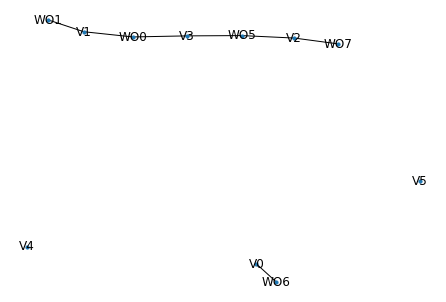

In [132]:
# Draw Graph with nodes and edges with coordinates
G=nx.Graph()
for i,j in vacant_spaces.items():
    G.add_node(i)
G.add_edges_from(nearby_waste100)
nx.draw(G, with_labels=True, node_size=10)

# Create a dictionary with vacant spaces and waste outputs them
new_waste_dict = create_edge_dict(G)
waste_dict = {}
for i,k in new_waste_dict.items():
    new_list = []
    if i in vacant_spaces:
        waste_dict[i]=k
        
#List of dictionaries we will use:
print(v_potential)
print(waste_dict)
print(uf_systems)

# add needed inputs for each potential system into the v_potential dictionary
v_potential_dict={}
for i,k in v_potential.items():
    v_potential_dict[i]={}
    potential_systems = v_potential[i]["UF"]
    for item in potential_systems:
       v_potential_dict[i][item] = uf_systems[item]["in"]
       
print(v_potential_dict)    
#Design Rule 1.0 : Waste Availability
    #if there are more than 2 found items assign that system to that vacant space

Design Rule 3.0 : Sharing Existing Resources
    

Prepare Data

In [133]:
# Preparation of Data
#Make a dictionary of found items nearby for each potential uf system
found_dict={}

for i,k in v_potential_dict.items():
    found_dict[i]={}
    for system,demanded in k.items():
        found_dict[i][system]={}
        found_dict[i][system]["found"]={}
        found_dict[i][system]["source"]={}
        found=[]
        source=[]
        for waste in waste_dict[i]:
            for each in demanded: 
                available = wastes[waste]["type"]
                source2 = wastes[waste]["tag"]
                source_size = wastes[waste]["size"]
                if each == available:
                    found.append(available)
                    source.append(source2)
                    found_dict[i][system]["found"]=found
                    found_dict[i][system]["source"]=source

#Make a dictionary of missing for each potential uf system           
for i,system in found_dict.items():
    for uf in system:
        missing=[]
        found_dict[i][uf]["missing"]={}
        for x,y in uf_systems.items():
            for item in uf_systems[x]["in"]:
                if uf == x:
                    missing.append(item)
                    found_dict[i][uf]["missing"]=missing
        
#In the dictionary missing items also contain found items
for i,k in found_dict.items():
    for system in k:
        for item in (found_dict[i][system]["found"]):
            if item in found_dict[i][system]["missing"]:
                missing_list=found_dict[i][system]["missing"]
                missing_list.remove(item)

#reach sizes of duplicate items
for i,k in found_dict.items():
    for system in k:
        found_items=found_dict[i][system]["found"]

#Make a dictionary holding each vacant space& found and repeating waste type & waste sources corresponding to found items
duplicate_items={}
for space,potential in found_dict.items():
    duplicate_items[space]={}
    for system, k in potential.items():
        if len(found_dict[space][system]["found"])> 1:
            found_items3=found_dict[space][system]["found"]
            sources=[]
            for index,items in enumerate(found_items3):
                duplicate_items[space][items]={}
                count=found_items3.count(items)
                if count>1:
                    items_str=str(items)
                    sources.append(found_dict[space][system]["source"][index])
                    duplicate_items[space][items]["matching sources"]=sources

# check if the total size of found waste matches the vacant space size

satisfying_duplicate={}

for space, k in duplicate_items.items():
    satisfying_duplicate[space]={}
    for key,value in k.items():
        satisfying_duplicate[space][key]={}
        waste_matched=[]
        not_matched=[]
        if duplicate_items[space][key]!=[]:
            for m,n in duplicate_items[space][key].items():
                matched=duplicate_items[space][key][m]
                for items in matched:
                    found_new=[]
                    waste_matched.append(wastes[items]["size"])
                    if sum(waste_matched)==vacant_spaces[space]["size"]:
                        # print(space, waste_matched, "add to found list and remove from missing")
                        found_new=matched
                        # print(found_new, "is found")
                    else:
                        # print(sum(waste_matched),"And",vacant_spaces[space]["size"],items)
                        not_matched=items
                        # print(not_matched,"is not matched")
                satisfying_duplicate[space][key]=found_new
                            
print(satisfying_duplicate) 

#remove duplicate items if they are also in satisfying_duplicate items list
for space,potential in found_dict.items():
    for system in potential.keys():
        for key, value in satisfying_duplicate.items():
            for waste in value.keys():
                if key==space:
                        if len(found_dict[space][system]["found"])>0:
                            if len(satisfying_duplicate[key][waste])>0:
                                if waste in found_dict[space][system]["found"]:
                                    type(satisfying_duplicate[key][waste])
                                    found_items = found_dict[space][system]["found"]
                                    duplicate=list_duplicates(found_items)
                                    for found in found_items:
                                        if found in duplicate:
                                            found_items.remove(found)                                                
print(found_dict)
#remove duplicate items if they are not in satisfying_duplicate items list

for space in found_dict.keys():
    for system in found_dict[space].keys():
        found_items = found_dict[space][system]["found"]
        missing_items = found_dict[space][system]["missing"]
        duplicate=list_duplicates(found_items)
        for key, value in satisfying_duplicate.items():
            for waste in value.keys():
                if key==space:
                    for found in found_items:
                        if found in duplicate:
                            print("duplicate",space,found,system)
                            if satisfying_duplicate[space][found]==[]:
                                print("duplicate not satisfying",space,found,system)
                                missing_items.append(found)
                                found_items.remove(found) 

#put not satisfying waste sources in a list
not_enough_waste=[]
for space in found_dict:
    for system in found_dict[space]:
        source=found_dict[space][system]["source"]
        for index in range(len(source)):
            item=source[index]
            waste=wastes[item]["type"]
            if waste in found_dict[space][system]["found"]:
                print("found")
            else:
                not_enough_waste.append(item) 

#remove the items in that list from found dict sources
for space in found_dict:
    for system in found_dict[space]:    
        source=found_dict[space][system]["source"]
        for item in not_enough_waste:
            if item in source:
                source.remove(item)                    #  
            
#remove duplicate items in missing list
for space in found_dict.keys():
    for system in found_dict[space].keys():
       missing_items2 = found_dict[space][system]["missing"]   
       duplicate=list_duplicates(missing_items2)
       for missing in missing_items2:
           if missing in duplicate:
               missing_items2.remove(missing) 
   
#add circularity percentage to found_dict
for space in found_dict:
    for system in found_dict[space]:
        found_dict[space][system]["circularity"]=[]
        found=len(found_dict[space][system]["found"])
        missing=len(found_dict[space][system]["missing"])
        total=found+missing
        found_dict[space][system]["circularity"]=found/total
print(found_dict)   

#make a duplicate of found dict, sort system based on circularities
sorted_dict={}
for space in found_dict:
    system=sorted(found_dict[space], key=lambda x: (found_dict[space][x]['circularity']), reverse=True)  
    sorted_dict[space]={} 
    for item in system:
        values={}
        values=(found_dict[space][item])
        sorted_dict[space][item]=values

print(sorted_dict)

{'V0': {}, 'V1': {}, 'V2': {}, 'V3': {}, 'V4': {}, 'V5': {}}
{'V0': {'UF4': {'found': ['W5'], 'source': ['WO6'], 'missing': ['W6', 'W7']}, 'UF5': {'found': ['W5'], 'source': ['WO6'], 'missing': ['W6', 'W7']}, 'UF6': {'found': {}, 'source': {}, 'missing': ['W6']}, 'UF7': {'found': ['W5'], 'source': ['WO6'], 'missing': ['W6', 'W7']}, 'UF9': {'found': ['W5'], 'source': ['WO6'], 'missing': ['W6']}}, 'V1': {'UF3': {'found': ['W4'], 'source': ['WO0'], 'missing': ['W2', 'W3', 'W6']}, 'UF8': {'found': ['W5'], 'source': ['WO1'], 'missing': ['W6']}}, 'V2': {'UF3': {'found': ['W3'], 'source': ['WO7'], 'missing': ['W2', 'W4', 'W6']}, 'UF8': {'found': ['W5'], 'source': ['WO5'], 'missing': ['W6']}}, 'V3': {'UF4': {'found': ['W5'], 'source': ['WO5'], 'missing': ['W6', 'W7']}, 'UF5': {'found': ['W5'], 'source': ['WO5'], 'missing': ['W6', 'W7']}, 'UF9': {'found': ['W5'], 'source': ['WO5'], 'missing': ['W6']}}, 'V4': {'UF3': {'found': {}, 'source': {}, 'missing': ['W2', 'W3', 'W4', 'W6']}}, 'V5': {'UF4'

Assign Food Production System To Vacant Space

In [134]:
#check if the criteria is satisfied
occupied={}
used_waste=[]
used_waste_source=[]
used_waste_source_temp=[]
new_edges=[]
occupied_dict={}

for space in sorted_dict:
    print("looking for", space)
    print("for",space,sorted_dict[space],"is possible")
    occupied_dict[space]={}
    occupied_dict[space]["system"]={}
    occupied_dict[space]["found"]={}
    occupied_dict[space]["source"]={}
    occupied_dict[space]["missing"]={}
    for index,system in enumerate(sorted_dict[space]):
        print("looking for system", system)
        occupied[space]={}
        occupied[space]["system"]={}
        found_list=sorted_dict[space][system]["found"]
        sources_list=sorted_dict[space][system]["source"]
        missing_list=sorted_dict[space][system]["missing"]
        print(len(missing_list),"is length for",space,system)

        if len(occupied[space]["system"])==0:
            print(space,"is not occupied run for",system)
            if len(missing_list)==0:    
                for source in sources_list:
                    if source in used_waste_source:
                        print(used_waste_source,"is used",space,system)
                        pass
                    elif source not in used_waste_source:
                        print(used_waste_source,"is used",space,system)
                        occupied[space]["system"]=system
                        occupied_dict[space]["system"]=system
                        occupied_dict[space]["found"]=sorted_dict[space][system]["found"]
                        occupied_dict[space]["source"]=sorted_dict[space][system]["source"]
                        for items in found_list:
                            used_waste.append(items)
                        used_waste_source.append(source)
                        edge_tuple=(source,space)
                        new_edges.append(edge_tuple)
                        print("no missing items:", space, system, "assign")
                if len(occupied[space]["system"])>0:
                    print(space,system,"will break")        
                    break
        
        if len(occupied[space]["system"])==0:
            if len(missing_list)==1:
                print("one item",system,space)
                for missing in missing_list:
                    if missing in non_critical_items:
                        for source in sources_list:
                            if source not in used_waste_source:
                                print("Used Non Critical Source",source)
                                occupied[space]["system"]=system
                                occupied_dict[space]["system"]=system
                                occupied_dict[space]["found"]=sorted_dict[space][system]["found"]
                                occupied_dict[space]["source"]=sorted_dict[space][system]["source"]
                                occupied_dict[space]["missing"]=sorted_dict[space][system]["missing"]
                                for items in found_list:
                                    used_waste.append(items)
                                used_waste_source.append(source)
                                edge_tuple=(source,space)
                                new_edges.append(edge_tuple)
                                print("one non critical missing items:", space, system, "assign")
                    else:
                        print(space,"critical item missing:",missing,"for",system)
                if len(occupied[space]["system"])>0:
                    print(space,system,"will break")        
                    break

        if occupied[space]["system"]==0 :  
            if len(missing_list)==2:
                for missing in missing_list:
                    if missing in non_critical_items:
                        for source in sources_list:
                            if source not in used_waste_source:
                                print("Used Non Critical Source",source)
                                occupied[space]["system"]=system
                                occupied_dict[space]["system"]=system
                                occupied_dict[space]["found"]=sorted_dict[space][system]["found"]
                                occupied_dict[space]["source"]=sorted_dict[space][system]["source"]
                                occupied_dict[space]["missing"]=sorted_dict[space][system]["missing"]
                                for items in found_list:
                                    used_waste.append(items)
                                print("two non critical missing items:", space, system)
                                used_waste_source.append(source)
                                edge_tuple=(source,space)
                                new_edges.append(edge_tuple)
                    else:
                        print(space,"critical item missing:",missing,"for",system)
                if len(occupied[space]["system"])>0:
                    print(space,system,"will break")        
                    break  

looking for V0
for V0 {'UF9': {'found': ['W5'], 'source': ['WO6'], 'missing': ['W6'], 'circularity': 0.5}, 'UF4': {'found': ['W5'], 'source': ['WO6'], 'missing': ['W6', 'W7'], 'circularity': 0.3333333333333333}, 'UF5': {'found': ['W5'], 'source': ['WO6'], 'missing': ['W6', 'W7'], 'circularity': 0.3333333333333333}, 'UF7': {'found': ['W5'], 'source': ['WO6'], 'missing': ['W6', 'W7'], 'circularity': 0.3333333333333333}, 'UF6': {'found': {}, 'source': {}, 'missing': ['W6'], 'circularity': 0.0}} is possible
looking for system UF9
1 is length for V0 UF9
V0 is not occupied run for UF9
one item UF9 V0
Used Non Critical Source WO6
one non critical missing items: V0 UF9 assign
V0 UF9 will break
looking for V1
for V1 {'UF8': {'found': ['W5'], 'source': ['WO1'], 'missing': ['W6'], 'circularity': 0.5}, 'UF3': {'found': ['W4'], 'source': ['WO0'], 'missing': ['W2', 'W3', 'W6'], 'circularity': 0.25}} is possible
looking for system UF8
1 is length for V1 UF8
V1 is not occupied run for UF8
one item UF8

Create New List To Be Used In Next Steps

In [135]:
print(occupied)  
print(used_waste_source) 
print(new_edges)
print(occupied_dict)
#add circularity & outputs to occupied_dict
for space in occupied_dict:
    occupied_dict[space]["circularity"]={}
    occupied_dict[space]["outputs"]={}
    occupied_dict[space]["supplements"]={}
    if len(occupied_dict[space]["system"])!=0:
        system=occupied_dict[space]["system"]
        outputs=(uf_systems[system]["out"])
        supplements=uf_systems[system]["supplement"]
        occupied_dict[space]["circularity"]=found_dict[space][system]["circularity"]
        occupied_dict[space]["supplements"]=supplements
        occupied_dict[space]["outputs"]=outputs

#remove empty spaces from occupied_dict
remove=[]
for space in occupied_dict:
    if len(occupied_dict[space]["system"])==0:
        remove.append(space)
for items in remove:
    occupied_dict.pop(items)
print("occupied",occupied_dict)

#remove assigned spaces from found_dict
remove2=[]
for space in sorted_dict:
    if space in occupied_dict:
        remove2.append(space)
for items in remove2:
    sorted_dict.pop(items)
print("non occupied",sorted_dict)

{'V0': {'system': 'UF9'}, 'V1': {'system': 'UF8'}, 'V2': {'system': 'UF8'}, 'V3': {'system': {}}, 'V4': {'system': {}}, 'V5': {'system': {}}}
['WO6', 'WO1', 'WO5']
[('WO6', 'V0'), ('WO1', 'V1'), ('WO5', 'V2')]
{'V0': {'system': 'UF9', 'found': ['W5'], 'source': ['WO6'], 'missing': ['W6']}, 'V1': {'system': 'UF8', 'found': ['W5'], 'source': ['WO1'], 'missing': ['W6']}, 'V2': {'system': 'UF8', 'found': ['W5'], 'source': ['WO5'], 'missing': ['W6']}, 'V3': {'system': {}, 'found': {}, 'source': {}, 'missing': {}}, 'V4': {'system': {}, 'found': {}, 'source': {}, 'missing': {}}, 'V5': {'system': {}, 'found': {}, 'source': {}, 'missing': {}}}
occupied {'V0': {'system': 'UF9', 'found': ['W5'], 'source': ['WO6'], 'missing': ['W6'], 'circularity': 0.5, 'outputs': ['O1', 'W1'], 'supplements': ['S2']}, 'V1': {'system': 'UF8', 'found': ['W5'], 'source': ['WO1'], 'missing': ['W6'], 'circularity': 0.5, 'outputs': ['O1', 'W1', 'W7'], 'supplements': ['S2']}, 'V2': {'system': 'UF8', 'found': ['W5'], 'sou

6. Assign Food Producing Supplementary Systems

Prepare Data

In [136]:
#look for a system that can supply needed supplement
#put the findings in a dictionary
v_supplement_fs={}
for space in occupied_dict:
    v_supplement_fs[space]={}
    v_supplement_fs[space]["supplement"]={}
    v_supplement_fs[space]["fs_system"]={}
    v_supplement_fs[space]["supplement"]={}
    v_supplement_fs[space]["supplement source"]={}
    v_supplement_fs[space]["fs_demand"]={}
    v_supplement_fs[space]["fs_demand source"]={}
    v_supplement_fs[space]["potential source"]={}
    supplement=occupied_dict[space]["supplements"]
    # print(supplement)
    if supplement!=None:
        for item in supplement:
            if item=="S2":
                for i in uf_systems:
                    out=uf_systems[i]["out"]
                    for input in uf_systems[i]["in"]:
                        if "S2" in out:
                            print("maybe",space, i)
                            v_supplement_fs[space]["fs_system"]=i
                            v_supplement_fs[space]["supplement"]=item
                            v_supplement_fs[space]["fs_demand"]=input
    else:
        v_supplement_fs[space]["fs_system"]=None
print(v_supplement_fs)

#created a dictionary for spaces which need supplement to store system, supplementing neighbor and supplement type
#for each space found what kind of system and supplement and input is necessary 

#look neighbors of supplement needing space to see if there is a potential neighbor
for space in v_supplement_fs:
    potential=[]
    for space2,neighbor in nearby_space:
        if space==space2:
            if len(v_supplement_fs[space]["supplement source"])==0:
                # print(neighbor,"is available")
                system=v_supplement_fs[space]["fs_system"]
                if (vacant_spaces[space]["size"]==vacant_spaces[neighbor]["size"]) and (vacant_spaces[neighbor]["structure"]>=uf_systems[system]["weight"]) and (vacant_spaces[neighbor]["solar"]>=uf_systems[system]["solar"]):
                    potential.append(neighbor)
                    # print(space,potential)
                    v_supplement_fs[space]["potential source"]=potential
# print(v_supplement_fs)

#check if potential sources have fs_demand
for space in v_supplement_fs:
    potential=v_supplement_fs[space]["potential source"]
    if len(v_supplement_fs[space]["supplement source"])==0:
        # print(vacant,len(v_supplement_fs[space]["supplement source"]),"---",v_supplement_fs[space]["supplement source"])
        for vacant in potential:
            nearby_list=waste_dict[vacant]
            for nearby in nearby_list:
                print(vacant, nearby,"is",wastes[nearby]["type"])
                if nearby not in used_waste_source:
                    print(nearby,"not used")
                    if v_supplement_fs[space]["fs_demand"]==wastes[nearby]["type"]:
                        print("for",space,vacant,"is potential and has",nearby,"as a source of",wastes[nearby]["type"])
                        v_supplement_fs[space]["supplement source"]=vacant
                        print(v_supplement_fs[space]["supplement source"])
                        v_supplement_fs[space]["fs_demand source"]=nearby
                        print(v_supplement_fs[space]["fs_demand source"])
                        used_waste_source.append(nearby)
                        edge_tuple1=(nearby,vacant)
                        edge_tuple2=(vacant,space)
                        new_edges.append(edge_tuple1)
                        new_edges.append(edge_tuple2)
                        if len(v_supplement_fs[space]["supplement source"])>0:
                            # print(space,system,"will break")        
                            break

            if len(v_supplement_fs[space]["supplement source"])>0:
                            # print(space,system,"will break2")        
                            break
                    
# print(v_supplement_fs)  
# print(used_waste_source) 
# print(new_edges)     
print("occupied",occupied_dict)

for space in v_supplement_fs:
    if len(v_supplement_fs[space]["fs_system"])!=0:
        if len(v_supplement_fs[space]["supplement source"])!=0:
            occ=v_supplement_fs[space]["supplement source"]
            occupied_dict[occ]={}
            occupied_dict[occ]["found"]=v_supplement_fs[space]["fs_demand"]
            occupied_dict[occ]["system"]=v_supplement_fs[space]["fs_system"]
            occupied_dict[occ]["source"]=v_supplement_fs[space]["fs_demand source"]
print(occupied_dict)

#make a dictionary of source: waste type: size: receiver:tuple
network_dict={}
for source,space in new_edges:
    type_list=[]
    network_dict[source]={}
    network_dict[source]["type"]={}
    network_dict[source]["size"]={}
    network_dict[source]["receiver"]={}

for source,space in new_edges:
    network_dict[source]["receiver"]=space
    if source in wastes:
        network_dict[source]["type"]=wastes[source]["type"]
        network_dict[source]["size"]=wastes[source]["size"]
    elif source in vacant_spaces:
        network_dict[source]["size"]=vacant_spaces[source]["size"]
        network_dict[source]["type"]=occupied_dict[source]["found"]
    
print(network_dict)

maybe V0 UF2
maybe V1 UF2
maybe V2 UF2
{'V0': {'supplement': 'S2', 'fs_system': 'UF2', 'supplement source': {}, 'fs_demand': 'W7', 'fs_demand source': {}, 'potential source': {}}, 'V1': {'supplement': 'S2', 'fs_system': 'UF2', 'supplement source': {}, 'fs_demand': 'W7', 'fs_demand source': {}, 'potential source': {}}, 'V2': {'supplement': 'S2', 'fs_system': 'UF2', 'supplement source': {}, 'fs_demand': 'W7', 'fs_demand source': {}, 'potential source': {}}}
occupied {'V0': {'system': 'UF9', 'found': ['W5'], 'source': ['WO6'], 'missing': ['W6'], 'circularity': 0.5, 'outputs': ['O1', 'W1'], 'supplements': ['S2']}, 'V1': {'system': 'UF8', 'found': ['W5'], 'source': ['WO1'], 'missing': ['W6'], 'circularity': 0.5, 'outputs': ['O1', 'W1', 'W7'], 'supplements': ['S2']}, 'V2': {'system': 'UF8', 'found': ['W5'], 'source': ['WO5'], 'missing': ['W6'], 'circularity': 0.5, 'outputs': ['O1', 'W1', 'W7'], 'supplements': ['S2']}}
{'V0': {'system': 'UF9', 'found': ['W5'], 'source': ['WO6'], 'missing': ['

In [137]:
#check if potential sources have fs_demand
#and assign
for space in v_supplement_fs:
    potential=v_supplement_fs[space]["potential source"]
    if len(v_supplement_fs[space]["supplement source"])==0:
        # print(vacant,len(v_supplement_fs[space]["supplement source"]),"---",v_supplement_fs[space]["supplement source"])
        for vacant in potential:
            nearby_list=waste_dict[vacant]
            for nearby in nearby_list:
                print(vacant, nearby,"is",wastes[nearby]["type"])
                if nearby not in used_waste_source:
                    print(nearby,"not used")
                    if v_supplement_fs[space]["fs_demand"]==wastes[nearby]["type"]:
                        print("for",space,vacant,"is potential and has",nearby,"as a source of",wastes[nearby]["type"])
                        v_supplement_fs[space]["supplement source"]=vacant
                        print(v_supplement_fs[space]["supplement source"])
                        v_supplement_fs[space]["fs_demand source"]=nearby
                        print(v_supplement_fs[space]["fs_demand source"])
                        used_waste_source.append(nearby)
                        edge_tuple1=(nearby,vacant)
                        edge_tuple2=(vacant,space)
                        new_edges.append(edge_tuple1)
                        new_edges.append(edge_tuple2)
                        if len(v_supplement_fs[space]["supplement source"])>0:
                            # print(space,system,"will break")        
                            break

            if len(v_supplement_fs[space]["supplement source"])>0:
                            # print(space,system,"will break2")        
                            break
                    
print(v_supplement_fs)  
print(used_waste_source) 
print(new_edges)     

{'V0': {'supplement': 'S2', 'fs_system': 'UF2', 'supplement source': {}, 'fs_demand': 'W7', 'fs_demand source': {}, 'potential source': {}}, 'V1': {'supplement': 'S2', 'fs_system': 'UF2', 'supplement source': {}, 'fs_demand': 'W7', 'fs_demand source': {}, 'potential source': {}}, 'V2': {'supplement': 'S2', 'fs_system': 'UF2', 'supplement source': {}, 'fs_demand': 'W7', 'fs_demand source': {}, 'potential source': {}}}
['WO6', 'WO1', 'WO5']
[('WO6', 'V0'), ('WO1', 'V1'), ('WO5', 'V2')]


In [138]:
print(occupied_dict)
for space in v_supplement_fs:
    if len(v_supplement_fs[space]["fs_system"])!=0:
        print("work")
        if len(v_supplement_fs[space]["supplement source"])!=0:
            occ=v_supplement_fs[space]["supplement source"]
            occupied_dict[occ]={}
            print(occupied_dict)
            occupied_dict[occ]["found"]=v_supplement_fs[space]["fs_demand"]
            occupied_dict[occ]["system"]=v_supplement_fs[space]["fs_system"]
            occupied_dict[occ]["source"]=v_supplement_fs[space]["fs_demand source"]
print(occupied_dict)

#make a dictionary of source: waste type: size: receiver:tuple
network_dict={}
for source,space in new_edges:
    type_list=[]
    network_dict[source]={}
    network_dict[source]["type"]={}
    network_dict[source]["size"]={}
    network_dict[source]["receiver"]={}

for source,space in new_edges:
    network_dict[source]["receiver"]=space
    if source in wastes:
        network_dict[source]["type"]=wastes[source]["type"]
        network_dict[source]["size"]=wastes[source]["size"]
    elif source in vacant_spaces:
        network_dict[source]["size"]=vacant_spaces[source]["size"]
        network_dict[source]["type"]=occupied_dict[source]["found"]

print(network_dict)

{'V0': {'system': 'UF9', 'found': ['W5'], 'source': ['WO6'], 'missing': ['W6'], 'circularity': 0.5, 'outputs': ['O1', 'W1'], 'supplements': ['S2']}, 'V1': {'system': 'UF8', 'found': ['W5'], 'source': ['WO1'], 'missing': ['W6'], 'circularity': 0.5, 'outputs': ['O1', 'W1', 'W7'], 'supplements': ['S2']}, 'V2': {'system': 'UF8', 'found': ['W5'], 'source': ['WO5'], 'missing': ['W6'], 'circularity': 0.5, 'outputs': ['O1', 'W1', 'W7'], 'supplements': ['S2']}}
work
work
work
{'V0': {'system': 'UF9', 'found': ['W5'], 'source': ['WO6'], 'missing': ['W6'], 'circularity': 0.5, 'outputs': ['O1', 'W1'], 'supplements': ['S2']}, 'V1': {'system': 'UF8', 'found': ['W5'], 'source': ['WO1'], 'missing': ['W6'], 'circularity': 0.5, 'outputs': ['O1', 'W1', 'W7'], 'supplements': ['S2']}, 'V2': {'system': 'UF8', 'found': ['W5'], 'source': ['WO5'], 'missing': ['W6'], 'circularity': 0.5, 'outputs': ['O1', 'W1', 'W7'], 'supplements': ['S2']}}
{'WO6': {'type': 'W5', 'size': 1, 'receiver': 'V0'}, 'WO1': {'type': 'W

In [139]:
#now we have food supplying supplementary systems
#we still need to check if these systems need supplements
for space in occupied_dict: 
    system=occupied_dict[space]["system"]
    # print(system)
    # print(uf_systems[system]["supplement"])
    value=uf_systems[system]["supplement"]
    for supplement in value:
        if supplement=="S5":
            v_supplement_fs[space]={}
            v_supplement_fs[space]["supplement"]=supplement
            for uf in uf_systems:
                for out in uf_systems[uf]["out"]:
                    if supplement == out:
                        v_supplement_fs[space]["fs_system"]=uf
                        v_supplement_fs[space]["fs_demand"]=uf_systems[uf]["in"]
            v_supplement_fs[space]["supplement source"]={}
            v_supplement_fs[space]["fs_demand source"]={}
            v_supplement_fs[space]["potential source"]={}
print(v_supplement_fs)

#make a potential list
for space in v_supplement_fs:
    potential=[]
    for space2,neighbor in nearby_space:
        if space==space2:
            if len(v_supplement_fs[space]["supplement source"])==0:
                print(neighbor,"is available")
                system=v_supplement_fs[space]["fs_system"]
                if (vacant_spaces[space]["size"]==vacant_spaces[neighbor]["size"]) and (vacant_spaces[neighbor]["structure"]>=uf_systems[system]["weight"]) and (vacant_spaces[neighbor]["solar"]>=uf_systems[system]["solar"]):
                    potential.append(neighbor)
                    print(space,potential)
                    v_supplement_fs[space]["potential source"]=potential
print(v_supplement_fs)

{'V0': {'supplement': 'S2', 'fs_system': 'UF2', 'supplement source': {}, 'fs_demand': 'W7', 'fs_demand source': {}, 'potential source': {}}, 'V1': {'supplement': 'S2', 'fs_system': 'UF2', 'supplement source': {}, 'fs_demand': 'W7', 'fs_demand source': {}, 'potential source': {}}, 'V2': {'supplement': 'S2', 'fs_system': 'UF2', 'supplement source': {}, 'fs_demand': 'W7', 'fs_demand source': {}, 'potential source': {}}}
V2 is available
V4 is available
V3 is available
V2 is available
V0 is available
V1 is available
{'V0': {'supplement': 'S2', 'fs_system': 'UF2', 'supplement source': {}, 'fs_demand': 'W7', 'fs_demand source': {}, 'potential source': {}}, 'V1': {'supplement': 'S2', 'fs_system': 'UF2', 'supplement source': {}, 'fs_demand': 'W7', 'fs_demand source': {}, 'potential source': {}}, 'V2': {'supplement': 'S2', 'fs_system': 'UF2', 'supplement source': {}, 'fs_demand': 'W7', 'fs_demand source': {}, 'potential source': {}}}


In [140]:
#check if potential sources have fs_demand
print(used_waste_source)
for space in v_supplement_fs:
    potential=v_supplement_fs[space]["potential source"]
    if len(v_supplement_fs[space]["supplement source"])==0:
        for vacant in potential:
            found=[]
            found_source=[]
            nearby_list=waste_dict[vacant]
            for nearby in nearby_list:
                print(vacant, nearby,"is",wastes[nearby]["type"])
                if nearby not in used_waste_source:
                    print(nearby,"not used")
                    found.append(wastes[nearby]["type"])
                    found_source.append(nearby)
                    print(found)
                    if v_supplement_fs[space]["fs_demand"]==found:
                        print("for",space,vacant,"is potential and has",nearby,"as a source of",wastes[nearby]["type"])
                        v_supplement_fs[space]["supplement source"]=vacant
                        print(v_supplement_fs[space]["supplement source"])
                        v_supplement_fs[space]["fs_demand source"]=found_source
                        print(v_supplement_fs[space]["fs_demand source"])
                        for x in found_source:
                            used_waste_source.append(x)
                            edge_tuple1=(x,vacant)
                            new_edges.append(edge_tuple1)
                        edge_tuple2=(vacant,space)
                        
                        new_edges.append(edge_tuple2)
                        if len(v_supplement_fs[space]["supplement source"])>0:
                            # print(space,system,"will break")        
                            break

            if len(v_supplement_fs[space]["supplement source"])>0:
                            # print(space,system,"will break2")        
                            break
                    
print(v_supplement_fs) 
print(new_edges)
print(used_waste_source)

['WO6', 'WO1', 'WO5']
{'V0': {'supplement': 'S2', 'fs_system': 'UF2', 'supplement source': {}, 'fs_demand': 'W7', 'fs_demand source': {}, 'potential source': {}}, 'V1': {'supplement': 'S2', 'fs_system': 'UF2', 'supplement source': {}, 'fs_demand': 'W7', 'fs_demand source': {}, 'potential source': {}}, 'V2': {'supplement': 'S2', 'fs_system': 'UF2', 'supplement source': {}, 'fs_demand': 'W7', 'fs_demand source': {}, 'potential source': {}}}
[('WO6', 'V0'), ('WO1', 'V1'), ('WO5', 'V2')]
['WO6', 'WO1', 'WO5']


In [141]:
coordinates=[]
#make a coordinate list for new_edges [(coordinates1,coordinates2),(coordinates1,coordinates2),(coordinates1,coordinates2)]
for item in new_edges:
        coordinate_tuple=(combined_dict[item[0]]["location"],combined_dict[item[1]]["location"])
        # print(coordinate_tuple)
        coordinates.append(coordinate_tuple)

print(coordinates)

for space in v_supplement_fs:
    if len(v_supplement_fs[space]["fs_system"])!=0:
        if len(v_supplement_fs[space]["supplement source"])!=0:
            occ=v_supplement_fs[space]["supplement source"]
            occupied_dict[occ]={}
            occupied_dict[occ]["found"]=v_supplement_fs[space]["fs_demand"]
            occupied_dict[occ]["system"]=v_supplement_fs[space]["fs_system"]
            occupied_dict[occ]["source"]=v_supplement_fs[space]["fs_demand source"]
            occupied_dict[occ]["outputs"]=v_supplement_fs[space]["supplement"]
print(occupied_dict)

#make a dictionary of source: waste type: size: receiver:tuple
network_dict={}
for source,space in new_edges:
    type_list=[]
    network_dict[source]={}
    network_dict[source]["type"]={}
    network_dict[source]["size"]={}
    network_dict[source]["receiver"]={}

for source,space in new_edges:
    network_dict[source]["receiver"]=space
    if source in wastes:
        network_dict[source]["type"]=wastes[source]["type"]
        network_dict[source]["size"]=wastes[source]["size"]
    elif source in vacant_spaces:
        network_dict[source]["size"]=vacant_spaces[source]["size"]
        network_dict[source]["type"]=occupied_dict[source]["outputs"]
    
# print(network_dict)

[('{-20.816152, 27.032718, 0}', '{64.79253, 69.821744, 0}'), ('{-70.863458, 35.713155, 0}', '{-53.645798, 20.542614, 0}'), ('{-64.048036, 3.817898, 0}', '{22.821687, 53.644416, 0}')]
{'V0': {'system': 'UF9', 'found': ['W5'], 'source': ['WO6'], 'missing': ['W6'], 'circularity': 0.5, 'outputs': ['O1', 'W1'], 'supplements': ['S2']}, 'V1': {'system': 'UF8', 'found': ['W5'], 'source': ['WO1'], 'missing': ['W6'], 'circularity': 0.5, 'outputs': ['O1', 'W1', 'W7'], 'supplements': ['S2']}, 'V2': {'system': 'UF8', 'found': ['W5'], 'source': ['WO5'], 'missing': ['W6'], 'circularity': 0.5, 'outputs': ['O1', 'W1', 'W7'], 'supplements': ['S2']}}


In [142]:
#combine wastes and vacant_spaces
workbook = load_workbook(filename="Node_coordinates.xlsx")
workbook.sheetnames
sheet1 = workbook.worksheets[0]
sheet2 = workbook.worksheets[1]

#update locations in dictionary based on excel worksheet
coordinate_list1=[]
for value in sheet1.iter_rows(min_row=2, values_only=True):
    for index,item in enumerate(value):
            coordinate=(value[0],value[1],value[2])
    coordinate_list1.append(coordinate)

for index1,space in enumerate(vacant_spaces):
    for index2,coordinate in enumerate(coordinate_list1):
        if index1==index2:
            vacant_spaces[space]["location"]=coordinate_list1[index2]

#update locations in dictionary based on excel worksheet
coordinate_list2=[]
for value in sheet2.iter_rows(min_row=2, values_only=True):
    for index,item in enumerate(value):
            coordinate=(value[0],value[1],value[2])
    coordinate_list2.append(coordinate)

for index1,space in enumerate(wastes):
    for index2,coordinate in enumerate(coordinate_list2):
        if index1==index2:
            wastes[space]["location"]=coordinate_list2[index2]

# print(vacant_spaces)
# print(wastes)
print(new_edges)


[('WO6', 'V0'), ('WO1', 'V1'), ('WO5', 'V2')]


In [143]:
combined_dict=vacant_spaces.copy()
combined_dict.update(wastes)

coordinates=[]
#make a coordinate list for new_edges [(coordinates1,coordinates2),(coordinates1,coordinates2),(coordinates1,coordinates2)]
for item in new_edges:
        coordinate_tuple=(combined_dict[item[0]]["location"],combined_dict[item[1]]["location"])
        # print(coordinate_tuple)
        coordinates.append(coordinate_tuple)

print(coordinates)

[((-20.816152, 27.032718, 0), (64.79253, 69.821744, 0)), ((-70.863458, 35.713155, 0), (-53.645798, 20.542614, 0)), ((-64.048036, 3.817898, 0), (22.821687, 53.644416, 0))]


In [144]:
#Make a dictionary of all spaces and systems
from collections import OrderedDict
export_dict={}
for space in vacant_spaces:
    export_dict[space]={}
    export_dict[space]["location"]={}
    export_dict[space]["system"]={}
    if space in occupied_dict:
        export_dict[space]["system"]=occupied_dict[space]["system"]
        export_dict[space]["location"]=combined_dict[space]["location"]
    else:
        export_dict[space]["system"]=None
        export_dict[space]["location"]=None
print(export_dict)

{'V0': {'location': (64.79253, 69.821744, 0), 'system': 'UF9'}, 'V1': {'location': (-53.645798, 20.542614, 0), 'system': 'UF8'}, 'V2': {'location': (22.821687, 53.644416, 0), 'system': 'UF8'}, 'V3': {'location': None, 'system': None}, 'V4': {'location': None, 'system': None}, 'V5': {'location': None, 'system': None}}


In [147]:
file = "occupied nodes.txt"
with open(str(file), 'w') as outfile:
    try:
        json.dump(export_dict, outfile)
        print(file + " has been updated successfully")
    except:
        print("Problem with updating file")

file = "new_edges.txt"
with open(str(file), 'w') as outfile:
    try:
        json.dump(new_edges, outfile)
        print(file + " has been updated successfully")
    except:
        print("Problem with updating file")

file = "coordinates.txt"
with open(str(file), 'w') as outfile:
    try:
        json.dump(coordinates, outfile)
        print(file + " has been updated successfully")
    except:
        print("Problem with updating file")

occupied nodes.txt has been updated successfully
new_edges.txt has been updated successfully
coordinates.txt has been updated successfully


8. INCREASING RADIUS

In [146]:
# # if space number in occupied dict / vacant spaces <0.75
# if len(occupied_dict)/len(vacant_spaces)<0.75:
#     updated_vacant_spaces=vacant_spaces
#     for occupied in occupied_dict:
#         updated_vacant_spaces.pop(occupied)
# print(updated_vacant_spaces)

# #remove co2,heat,water sources in waste50 from waste200 (w5,w6,w7)
# for couple50 in nearby_waste50:
#     for couple200 in nearby_waste200:
#         for item50 in couple50:
#             if item50 in couple200:
#                 if item50 in wastes:
#                     if (wastes[item50]["type"]=="W5") or (wastes[item50]["type"]=="W6") or (wastes[item50]["type"]=="W7"):
#                         nearby_waste200.remove(couple200)
#                     else:
#                         print("more than 75% occupied")
# nearby_waste200=tuple(nearby_waste200)